In [2]:
## modelling HH crude front month prices based on markov regime switching model ##

import numpy as np
import pandas as pd
import math
import datetime as dt
import datapackage
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.stats import multinomial
from typing import List
import seaborn as sns

## state definitions s.t. Sn = (mean,variance)

p_init = np.array([1, 0, 0])
## S1 = State(0,0)
## S2 = State(-0.0431,9.2698)
## S3 = State(0.9739,110.3372)
        
## state transition matrix definition ## 

pT = np.array([[0.2846,0.6879,0.0275], [0.1704,0.8071,0.0225],[0.1458,0.4660,0.3882]])
print(pT)

[[0.2846 0.6879 0.0275]
 [0.1704 0.8071 0.0225]
 [0.1458 0.466  0.3882]]


In [3]:
def equilibrium_distribution(pS):
    n_states = pS.shape[0]
    A = np.append(
        arr=pS.T - np.eye(n_states),
        values=np.ones(n_states).reshape(1, -1),
        axis=0
    )
    b = np.transpose(np.array([0] * n_states + [1]))
    p_eq = np.linalg.solve(
        a=np.transpose(A).dot(A),
        b=np.transpose(A).dot(b)
    )
    return p_eq

print(equilibrium_distribution(pT))

[0.19134148 0.77167806 0.03698046]


In [4]:
def markov_sequence(p_init: np.array, pT: np.array, sequence_length: int) -> List[int]:
    """
    Generate a Markov sequence based on p_init and p_transition.
    """
    if p_init is None:
        p_init = equilibrium_distribution(pT)
    initial_state = list(multinomial.rvs(1, p_init)).index(1)

    states = [initial_state]
    for _ in range(sequence_length - 1):
        p_tr = pT[states[-1]]
        new_state = list(multinomial.rvs(1, p_tr)).index(1)
        states.append(new_state)
    return states

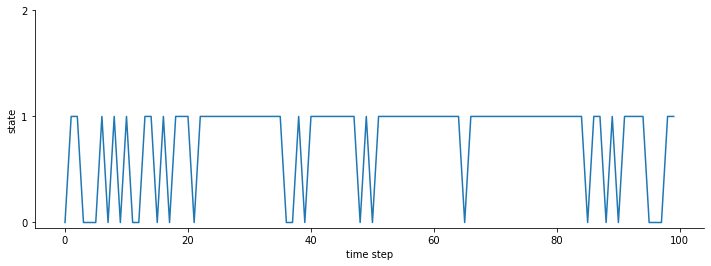

In [5]:
## generate markov sequence given available data ##

states = markov_sequence(p_init, pT, sequence_length=100)
fig,  ax = plt.subplots(figsize=(12, 4))
plt.plot(states)
plt.xlabel("time step")
plt.ylabel("state")
plt.yticks([0, 1, 2])
sns.despine()

In [6]:
def plot_prices(states, prices):
    fig, axes = plt.subplots(figsize=(16, 8), nrows=2, ncols=1, sharex=True)

    axes[0].plot(states)
    axes[0].set_title("States")
    axes[1].plot(prices)
    axes[1].set_title("Prices")
    sns.despine();

In [7]:
def price_evo_gaussian(states: List[int], mus: List[float], sigmas: List[float]) -> List[float]:
    prices = []
    prev_loc = 2.96
    for state in states:
        price = prev_loc*(1+(norm.rvs(mus[state],sigmas[state])))
        prices.append(price)
        prev_loc = price
    return prices

In [8]:
mus=[0,0.0028,0.0668]
sigmas = [0,0.03605,0.2357]

hh_prices = price_evo_gaussian(states,mus,sigmas)

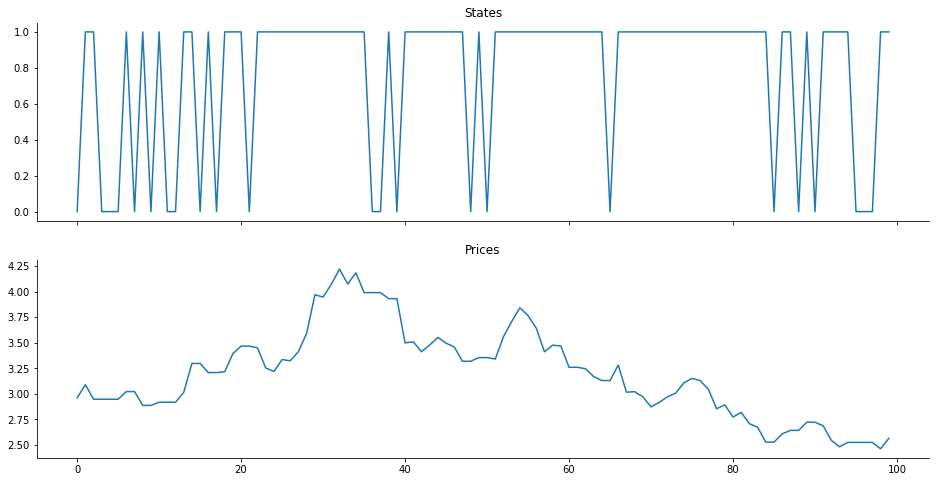

In [9]:
plot_prices(states,hh_prices)